# 3) Calculate BG Distances

## Env

In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import pickle
import os


## Process

### Load Data

In [5]:
import pickle
# Load the centroids
with open('../data/temp/bg_centroids', 'rb') as f:
    BG_centroids = pickle.load(f)

# Load the projections
with open('../data/temp/projections', 'rb') as f:
    PROJ = pickle.load(f)

# Load the Projected Graphs
Gps = {}
for i in ['nyc','phi','chi','sfba']:
    print(f'Trying to open {i}..')
    try:
        with open(f'../data/temp/{i}_walk_graph_proj_simpl', 'rb') as f:
            Gps[i] = pickle.load(f)
        print('\tSuccess!')
    except Exception as e:
        print(f'\tFailed with exception: {e}')

Trying to open nyc..
	Success!
Trying to open phi..
	Success!
Trying to open chi..
	Success!
Trying to open sfba..
	Success!


### Project each BG into coordinate system

#### First Clean the centroids

In [38]:
convert_dict = {
    '36': 'nyc',
    '06': 'sfba',
    '17': 'chi',
    '42': 'phi'
}

# BG_centroids
# with open('../data/temp/bg_centroids', 'wb') as fp:
#     pickle.dump(BG_centroids, fp)

#### Then project the centroids

In [22]:
import geopandas as gpd
BG_centroids.columns = ['fips12','lng','lat']

#bg_coords = BG_centroids.apply(lambda x: (x['LATITUDE'], x['LONGITUDE']), axis = 1)
gdf_BG_centroids = gpd.GeoDataFrame(BG_centroids, geometry=gpd.points_from_xy(BG_centroids['lng'], BG_centroids['lat']), crs='EPSG:4326')

with open('../data/temp/gdf_bg_centroids', 'wb') as fp:
    pickle.dump(gdf_BG_centroids, fp)

In [39]:
with open('../data/temp/gdf_bg_centroids', 'rb') as fp:
    gdf_BG_centroids = pickle.load(fp)

gdf_BG_centroids['fips12'] = gdf_BG_centroids['fips12'].astype('str').str.pad(12,'left','0')
gdf_BG_centroids['fips5'] = gdf_BG_centroids['fips12'].str[0:5]
gdf_BG_centroids['metro'] = gdf_BG_centroids['fips12'].str[0:2].apply(lambda x: convert_dict[x])

In [40]:
gdf_BG_centroids

,fips12,lng,lat,geometry,fips5,metro
0,421010001011,-75.1502,39.9518,POINT (-75.1502 39.9518),42101,phi
1,421010001012,-75.1500,39.9500,POINT (-75.15 39.95),42101,phi
2,421010001013,-75.1479,39.9515,POINT (-75.1479 39.9515),42101,phi
3,421010001014,-75.1456,39.9503,POINT (-75.1456 39.9503),42101,phi
4,421010001015,-75.1427,39.9500,POINT (-75.1427 39.95),42101,phi
...,...,...,...,...,...,...
4370,060855130003,-122.1588,37.4251,POINT (-122.1588 37.4251),06085,sfba
4371,060855130004,-122.1579,37.4218,POINT (-122.1579 37.4218),06085,sfba
4372,060855130005,-122.1547,37.4243,POINT (-122.1547 37.4243),06085,sfba
4373,060855130006,-122.1615,37.4315,POINT (-122.1615 37.4315),06085,sfba


### Load the Projected Simplified Graphs


In [4]:
# Load the Simplififed Projected Graphs
Gps = {}
for i in PROJ.keys():
    print(f'Trying to open {i}..')
    try:
        with open(f'../data/temp/{i}_walk_graph_proj_simpl', 'rb') as f:
            Gps[i] = pickle.load(f)
        print('\tSuccess!')
    except Exception as e:
        print(f'\tFailed with exception: {e}')

Trying to open phi..
	Success!
Trying to open chi..
	Success!
Trying to open sfba..
	Success!
Trying to open sf..
	Failed with exception: [Errno 2] No such file or directory: '../data/temp/sf_walk_graph_proj_simpl'
Trying to open eastbay..
	Failed with exception: [Errno 2] No such file or directory: '../data/temp/eastbay_walk_graph_proj_simpl'
Trying to open nyc..
	Success!



### Assign each to a closest node

In [41]:
gdf_BGs = {}

for i in Gps.keys():
    print(f'{i}..')
    # first create a metro-specific block group
    gdf_BGs[i] = gdf_BG_centroids[gdf_BG_centroids['metro'] == i].set_index('fips12')
    # then create nearest nodes
    nn_idxs, nn_dists = ox.distance.nearest_nodes(
        Gps[i], 
        X = gdf_BGs[i].to_crs(PROJ[i])['geometry'].x,
        Y = gdf_BGs[i].to_crs(PROJ[i])['geometry'].y,
        return_dist=True
    )

    gdf_BGs[i]['nn_idx'] = nn_idxs
    gdf_BGs[i]['nn_dist'] = nn_dists

nyc..
phi..
chi..
sfba..


### For each node in "nearest_nodes", run dijkstra, to find shortest path to ALL nodes

In [42]:
# first limit to only those node pairs within 4mi of each other. Hmm, ok, that doesn't actually work. But can I use a cutoff?
# Yes!
shortest_paths = {}
for m in gdf_BGs.keys():
    print(f'\n{m}...')
    shortest_paths[m] = {}
    ctr = 0
    for i, row in gdf_BGs[m].iterrows():
        ctr = ctr + 1
        if ctr % 100 == 0:
            print(f'{ctr}/{gdf_BGs[m].shape[0]}')
        shortest_paths[m][row['nn_idx']] = nx.single_source_dijkstra_path_length(Gps[m], row['nn_idx'], weight='length', cutoff=4000)



nyc...
100/6352
200/6352
300/6352
400/6352
500/6352
600/6352
700/6352
800/6352
900/6352
1000/6352
1100/6352
1200/6352
1300/6352
1400/6352
1500/6352
1600/6352
1700/6352
1800/6352
1900/6352
2000/6352
2100/6352
2200/6352
2300/6352
2400/6352
2500/6352
2600/6352
2700/6352
2800/6352
2900/6352
3000/6352
3100/6352
3200/6352
3300/6352
3400/6352
3500/6352
3600/6352
3700/6352
3800/6352
3900/6352
4000/6352
4100/6352
4200/6352
4300/6352
4400/6352
4500/6352
4600/6352
4700/6352
4800/6352
4900/6352
5000/6352
5100/6352
5200/6352
5300/6352
5400/6352
5500/6352
5600/6352
5700/6352
5800/6352
5900/6352
6000/6352
6100/6352
6200/6352
6300/6352

phi...
100/1338
200/1338
300/1338
400/1338
500/1338
600/1338
700/1338
800/1338
900/1338
1000/1338
1100/1338
1200/1338
1300/1338

chi...
100/4002
200/4002
300/4002
400/4002
500/4002
600/4002
700/4002
800/4002
900/4002
1000/4002
1100/4002
1200/4002
1300/4002
1400/4002
1500/4002
1600/4002
1700/4002
1800/4002
1900/4002
2000/4002
2100/4002
2200/4002
2300/4002
2400/4002
250

In [54]:
pd.DataFrame(shortest_paths['chi']).head(5)

gdf_BGs['chi']
#chi_nn_idxs = gdf_BGs['chi'].nn_idx.unique

# (
#     pd.DataFrame(shortest_paths['chi'])
#     .loc[]

#pd.DataFrame(shortest_paths['chi']).loc[nn_idxs[m]]
nn_idxs[m]
#     .melt()
#     .dropna()
#     .reset_index()
#     # .join(
#     #     on = {'index':'
#     # )
#     .rename(columns={'index':'o', 'variable':'d'})
#     .set_index(['o','d'])
# ) # 243,416 rows
# 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [43]:
shortest_paths['chi'].keys()

dict_keys([61153, 71122, 51778, 62788, 62735, 62765, 54452, 63992, 71191, 51469, 59343, 54835, 52760, 54023, 61392, 54273, 59393, 59350, 51391, 53741, 53392, 63174, 53739, 52754, 52758, 54220, 52756, 59361, 59319, 59300, 59807, 59313, 59809, 51882, 59235, 182551, 209461, 182136, 137004, 184268, 239624, 182539, 171534, 169789, 145420, 54628, 54621, 71153, 52575, 63454, 61000, 59204, 174894, 158491, 151968, 145410, 145404, 136985, 136990, 182560, 182255, 157725, 157664, 157665, 214395, 145386, 171518, 171515, 145388, 145389, 157652, 157653, 145396, 63361, 55860, 63373, 64045, 51440, 59947, 70439, 71600, 70425, 70388, 64911, 71830, 62563, 71809, 70431, 53734, 52471, 52771, 52772, 63421, 63430, 60062, 60053, 62900, 67893, 63050, 63010, 70440, 66781, 70824, 70446, 66782, 63978, 61403, 49673, 65659, 67773, 65663, 63078, 70449, 63018, 57807, 61228, 50391, 50384, 50386, 59988, 60029, 60040, 60098, 50413, 50274, 68746, 60241, 62293, 56059, 64738, 71903, 63958, 50194, 70987, 51052, 63940, 63939,

In [ ]:
temp = 

In [146]:
#gdf_BGs['phi'].nn_idx
print(temp.shape)
#gdf_BGs['phi']['nn_idx'].value_counts()


# FINAL BG Distance Logic
bg_dists = {}
for metro in ['sfba','phi','chi','nyc']:
    print(f'{metro}..')

    nn2bg = gdf_BGs[metro]['nn_idx'].reset_index().set_index('nn_idx')
    
    bg_dists[metro] = (
        pd.DataFrame(shortest_paths[metro])
        .loc[gdf_BGs[metro]['nn_idx']]
        .reset_index()
        .melt(id_vars='index')
        .rename(columns={'index':'o_node','variable':'d_node'})
        # .shape # 1,787,568 (1.7M)
        .merge(
            nn2bg,
            right_index=True,
            left_on = 'o_node'
        )
        #.shape # 1,792,912 (1.8M)
        .merge(
            nn2bg,
            right_index=True,
            left_on = 'd_node'
        )
        # .shape # 1,795,596
        .rename(columns={'fips12_x': 'fips12_o','fips12_y':'fips12_d'})
        .set_index(['fips12_o','fips12_d'])
    )

(55435, 1336)
sfba..
phi..
chi..
nyc..


In [154]:
bg_dists_notna = {}
for metro in bg_dists.keys():
    bg_dists_notna[metro] = bg_dists[metro][bg_dists[metro]['value'].notna()]
    with open(f'../data/temp/bg_dists_{metro}', 'wb') as fp:
        pickle.dump(bg_dists_notna[metro], fp)


In [158]:
with open('../data/temp/gdf_bg_centroids','wb') as fp:
    pickle.dump(gdf_BG_centroids,fp)

In [126]:
temp3 = nx.single_source_dijkstra_path_length(Gps['chi'], gdf_BGs['chi'].loc['170310101001']['nn_idx'], weight='length', cutoff=4000)
#gdf_BGs['chi'].loc['170310101001']['nn_idx']
#gdf_BGs['chi'].reset_index().set_index('nn_idx')['fips12']
temp

nn_idx
61153     170310101001
71122     170310101002
51778     170310101003
62788     170310102011
62735     170310102012
              ...     
218931    170318447002
175656    170318447003
257308    170319800001
102051    170319801001
68949     170319900000
Name: fips12, Length: 4002, dtype: object

In [170]:
gdf_BGs['chi'].loc['170310101001']['nn_idx']

61153

,metro,fips5,lng,lat,geometry,nn_idx,nn_dist
fips12,,,,,,,
170310101001,chi,17031,-87.6683,42.0222,POINT (-87.6683 42.0222),61153,84.203794
170310101002,chi,17031,-87.6728,42.0214,POINT (-87.6728 42.0214),71122,36.970332
170310101003,chi,17031,-87.6664,42.0206,POINT (-87.6664 42.0206),51778,45.766654
170310102011,chi,17031,-87.6819,42.0144,POINT (-87.6819 42.0144),62788,79.135798
170310102012,chi,17031,-87.6777,42.0147,POINT (-87.6777 42.0147),62735,45.434639
...,...,...,...,...,...,...,...
170318447002,chi,17031,-87.7163,41.8529,POINT (-87.7163 41.8529),218931,65.767066
170318447003,chi,17031,-87.7076,41.8554,POINT (-87.7076 41.8554),175656,22.125046
170319800001,chi,17031,-87.9038,41.9803,POINT (-87.9038 41.9803),257308,1328.264871


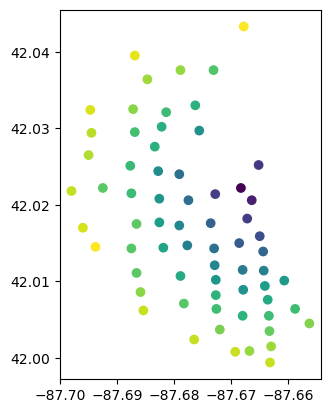

In [232]:
# gdf_BGs['chi'].reset_index().set_index('nn_idx')['fips12']
#pd.Series(temp3)
#pd.DataFrame(columns =temp3, gdf_BGs['chi'].reset_index().set_index('nn_idx')['fips12'])
# pd.concat([
#         pd.Series(temp3), # so idx is the node_id
#         gdf_BGs['chi'].reset_index().set_index('nn_idx')['fips12'] # idx is node_id, value 
#     ],
#     axis=1
# )

# #pd.Series(temp3).index.value_counts(sort=False)
# #print(gdf_BGs['chi'].reset_index().set_index('nn_idx')['fips12'].index.value_counts().head(10))
# #gdf_BGs['chi']

# #shortest_paths['chi']
# gdf_BGs['chi'].reset_index().set_index('nn_idx').loc[gdf_BGs['chi'].nn_idx.value_counts().head(5).index]
# print(pd.Series(temp3))


# temp3 = distance of all from each 
# dists_to_other_nodes = pd.DataFrame({'dist': pd.Series(temp3)})#.loc[gdf_BGs['chi'].nn_idx]
# print(dists_to_other_nodes)
# print(gdf_BGs['chi'])
joined = gdf_BGs['chi'].join(dists_to_other_nodes, on = 'nn_idx')
joined['total_dist'] = joined['dist'] + joined['nn_dist']

joined.plot(column='total_dist', cmap='viridis')



In [169]:
shortest_paths['chi'].keys()

dict_keys(['170310101001', '170310101002', '170310101003', '170310102011', '170310102012', '170310102013', '170310102014', '170310102021', '170310102022', '170310103001', '170310103002', '170310103003', '170310103004', '170310104001', '170310104002', '170310104003', '170310105011', '170310105012', '170310105013', '170310105021', '170310105022', '170310105031', '170310105032', '170310106001', '170310106002', '170310106003', '170310106004', '170310107011', '170310107012', '170310107021', '170310107022', '170310107023', '170310107024', '170310201001', '170310201002', '170310202001', '170310202002', '170310202003', '170310202004', '170310203011', '170310203012', '170310203013', '170310203021', '170310203022', '170310203023', '170310204001', '170310204002', '170310204003', '170310205001', '170310205002', '170310205003', '170310205004', '170310206011', '170310206012', '170310206013', '170310206021', '170310206022', '170310206023', '170310206024', '170310207011', '170310207012', '170310207021

In [100]:
# temp = pd.DataFrame(shortest_paths['chi']).loc[gdf_BGs['chi']['nn_idx']]
# temp.columsn = gdf['chi']
# pd.DataFrame(shortest_paths['chi']).shape # (262328, 4002)
shortest_paths['chi']
# temp = pd.DataFrame(shortest_paths['chi']).loc[nn_idxs['chi']]
# temp.columns = gdf['chi']
# temp_melted = (
#     temp
#     .melt()
#     .dropna()
#     .reset_index()
#     .rename(columns={'index':'o', 'variable':'d'})
# )

# temp_melted['o']

# # TODO: the stored indices aren't right. I need to replace them with the actual block group id numbers


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

In [69]:
# temp_melted.d.value_counts()
nn_idxs

{'phi': array([32434, 32425, 54647, ..., 38115, 47230, 47187]),
 'chi': array([ 61153,  71122,  51778, ..., 257308, 102051,  68949]),
 'sfba': array([249504, 261001, 260752, ...,  62312,  69196,   5117]),
 'nyc': array([58964, 29121, 50983, ..., 36202, 38376, 36371])}

In [16]:
bgs = {}
for m in ['sfba','chi','phi','nyc']:
    bgs[m] = gdf_BG_centroids[gdf_BG_centroids['metro'] == m]

KeyError: 'metro'

In [54]:
# bgs['chi'][temp_melted['o']]
# bgs['chi'].loc[temp_melted['o']]
# bgs['sfba'].value_counts('fips12')

fips12
060014001001    1
060816059021    1
060816061002    1
060816061001    1
060816060003    1
               ..
060133400033    1
060133400041    1
060133400042    1
060133400043    1
060855135001    1
Name: count, Length: 4375, dtype: int64

In [59]:
shortest_paths

KeyboardInterrupt: 

### Limit to just nodes in "nearest_nodes", then we have a table of O(NN*NN) 

In [58]:
dfs_shortest_paths = {}

for m in ['chi','phi','nyc','sfba']:
    dfs_shortest_paths[m] = (
        pd.DataFrame(shortest_paths[m])
        .loc[nn_idxs[m]]
        .melt()
        .dropna()
        .reset_index()
        .join(
            on = {'index':'
        )
        .rename(columns={'index':'o', 'variable':'d'})
        .set_index(['o','d'])
    ) # 243,416 rows

    dfs_shortest_paths['phi'] = pd.DataFrame(shortest_paths['phi']).loc[nn_idxs['phi']].melt().dropna().reset_index().rename(columns={'index':'o', 'variable':'d'}).set_index(['o','d'])

    dfs_shortest_paths['nyc'] = pd.DataFrame(shortest_paths['nyc']).loc[nn_idxs['nyc']].melt().dropna().reset_index().rename(columns={'index':'o', 'variable':'d'}).set_index(['o','d'])

    dfs_shortest_paths['sfba'] = pd.DataFrame(shortest_paths['sfba']).loc[nn_idxs['sfba']].melt().dropna().reset_index().rename(columns={'index':'o', 'variable':'d'}).set_index(['o','d'])

SyntaxError: EOL while scanning string literal (1394918505.py, line 11)

NameError: name 'dfs_shortest_paths' is not defined

### And Check in

In [56]:
print(dfs_shortest_paths['chi'].shape)
print(dfs_shortest_paths['phi'].shape)
print(dfs_shortest_paths['nyc'].shape)
print(dfs_shortest_paths['sfba'].shape)

NameError: name 'dfs_shortest_paths' is not defined

### Save Somehow

In [1]:
shortest_paths

NameError: name 'shortest_paths' is not defined

In [13]:
# pickle them?
for m in dfs_shortest_paths.keys():
    with open(f'../data/temp/{m}_shortest_paths', 'wb') as fp:
        pickle.dump(dfs_shortest_paths[m], fp)

NameError: name 'GEO_DEFINITIONS' is not defined